# 5章 OpenStreetMap：OSMnxで地理空間データにアクセスする

## 5.1 OpenStreetMapのコンセプト

### 5.1.1 タグ

### 5.1.2 多重有向グラフ

## 5.2 OSMnxのインストール

## 5.3 場所の選択

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('default')
import pandas as pd
import geopandas as gpd

In [2]:
%matplotlib inline

場所を選択する際、入力する住所などの文字列は日本の住所表記（例, 東京都新宿区....など）ではなく"新宿区, 東京都, 日本"などと表記する必要がある。  
そういった表記を確認するために[Nominatim](https://nominatim.openstreetmap.org/ui/search.html)というサイトにて地名を検索するとOpenStreetMapでの検索に適した表記を確認することができる。

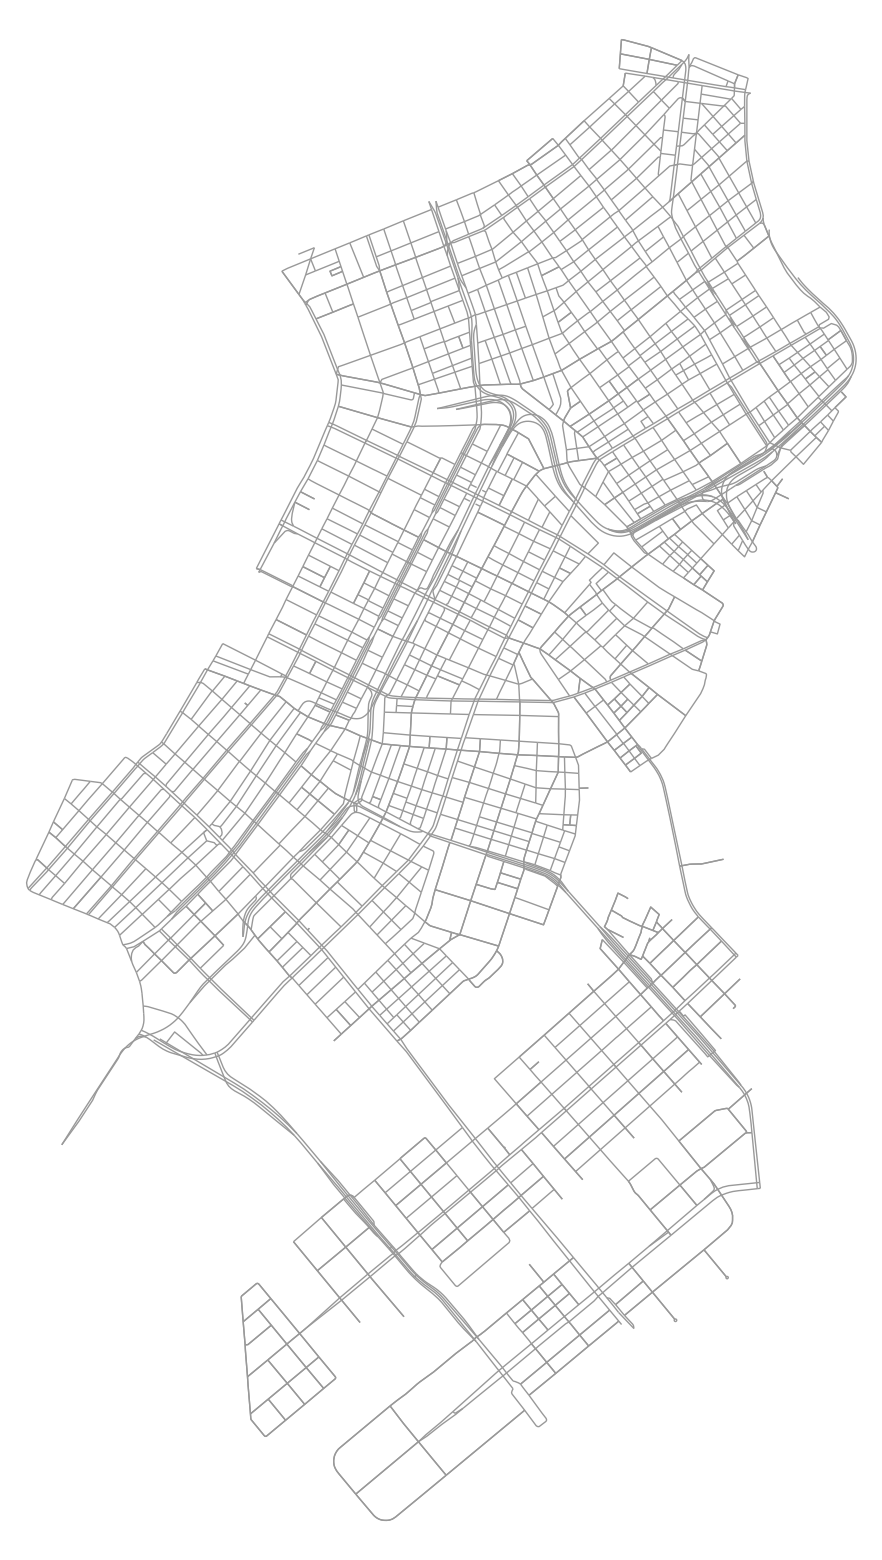

In [3]:
# ある都市の道路網をダウンロード/モデリングし、それを可視化
G = ox.graph_from_place("中央区, 東京都, 日本", network_type="drive")
G = ox.truncate.largest_component(G, strongly=False)

fig, ax = ox.plot_graph(G, figsize=(20, 20), bgcolor='#FFFFFF', node_color='black', node_size=0)

## 5.4 引数とパラメータを理解する

## 5.5 移動時間の計算

書籍上ではspeedと記載されていたが、正しくは**routing**  
また、add_edge_speedsやadd_edge_travel_timesのオプション**precision**もバージョンアップが要因か廃止されている  
例）  
✗：ox.speed.add_edge_speeds(G, hwy_speeds=None, fallback=None, precision=1)  
◯：ox.routing.add_edge_speeds(G, hwy_speeds=None, fallback=None, precision=1)


In [4]:
ox.routing.add_edge_speeds(G, hwy_speeds=None, fallback=None)
ox.routing.add_edge_travel_times(G)

In [5]:
print(f"{len(G)=:,}")

len(G)=2,208


In [6]:
print(f"{len(list(G.nodes))=:,}")

len(list(G.nodes))=2,208


In [7]:
print(f"{list(G.nodes)[-1]=}")

list(G.nodes)[-1]=12049316057


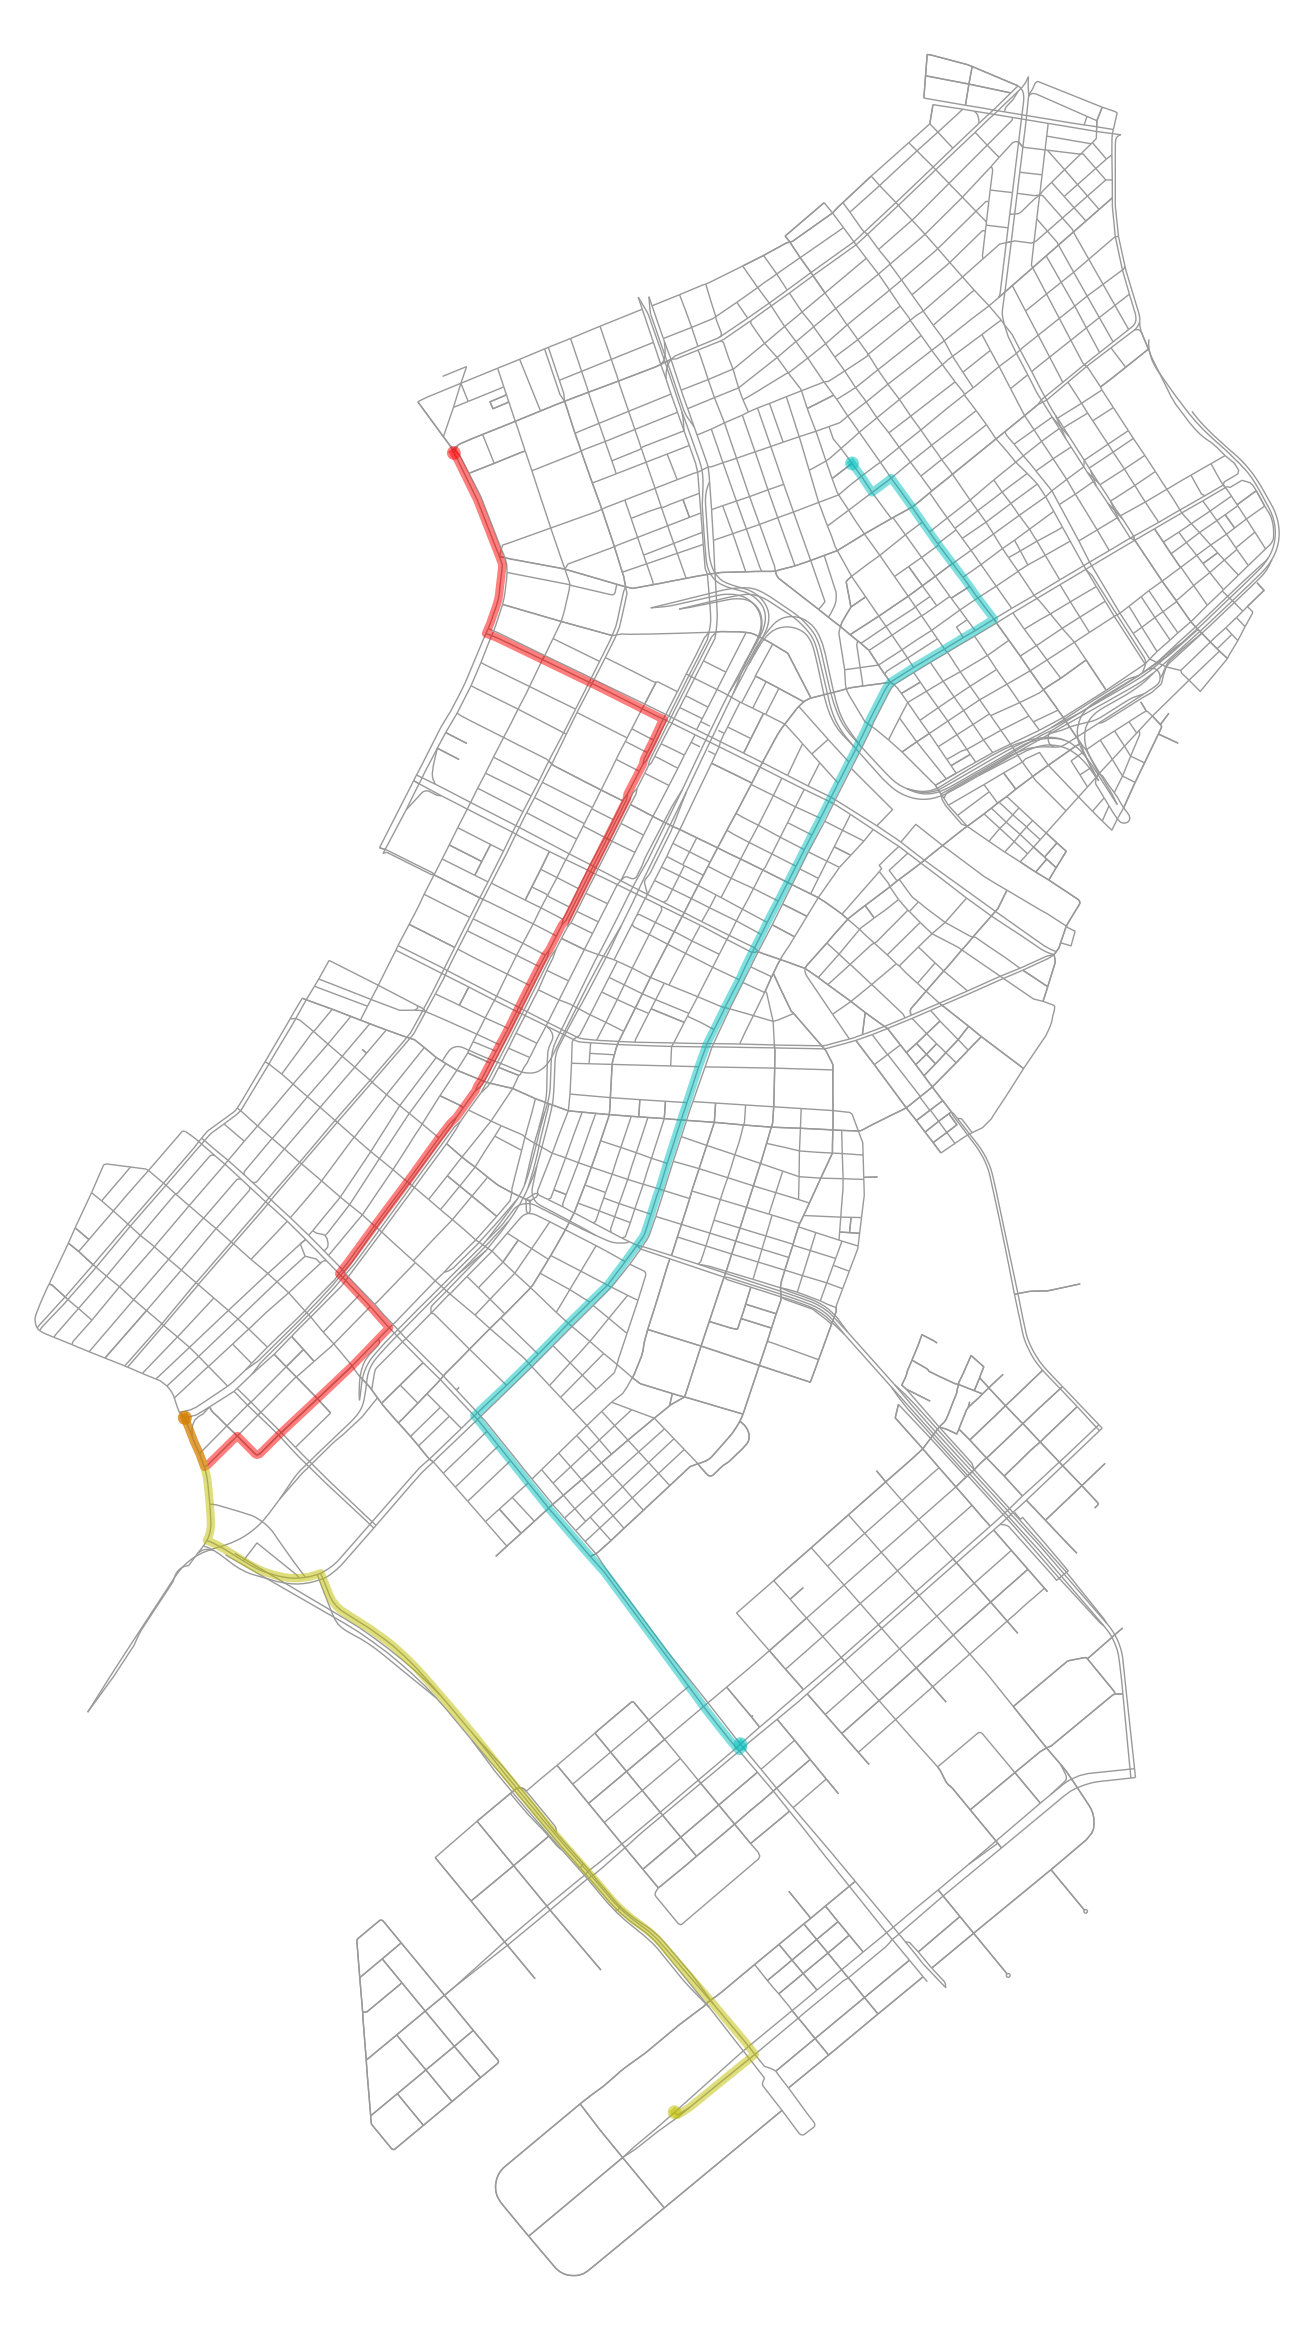

In [8]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
# 最大の連結成分だけを使う（ネットワーク内で最も大きな「繋がっている部分」だけを抽出する）
# G = ox.utils_graph.get_largest_component(G, strongly=False)


w = 'travel_time'
orig, dest = list(G)[10], list(G)[-10]
route1 = nx.shortest_path(G, orig, dest, weight=w)
orig, dest = list(G)[10], list(G)[-5]
route2 = nx.shortest_path(G, orig, dest, weight=w)
orig, dest = list(G)[50], list(G)[-50]
route3= nx.shortest_path(G, orig, dest, weight=w)

routes = [route1, route2, route3]
rc = ['r', 'y', 'c']
fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, route_linewidths=6, figsize=(30, 30), node_size=0, bgcolor="#FFFFFF")

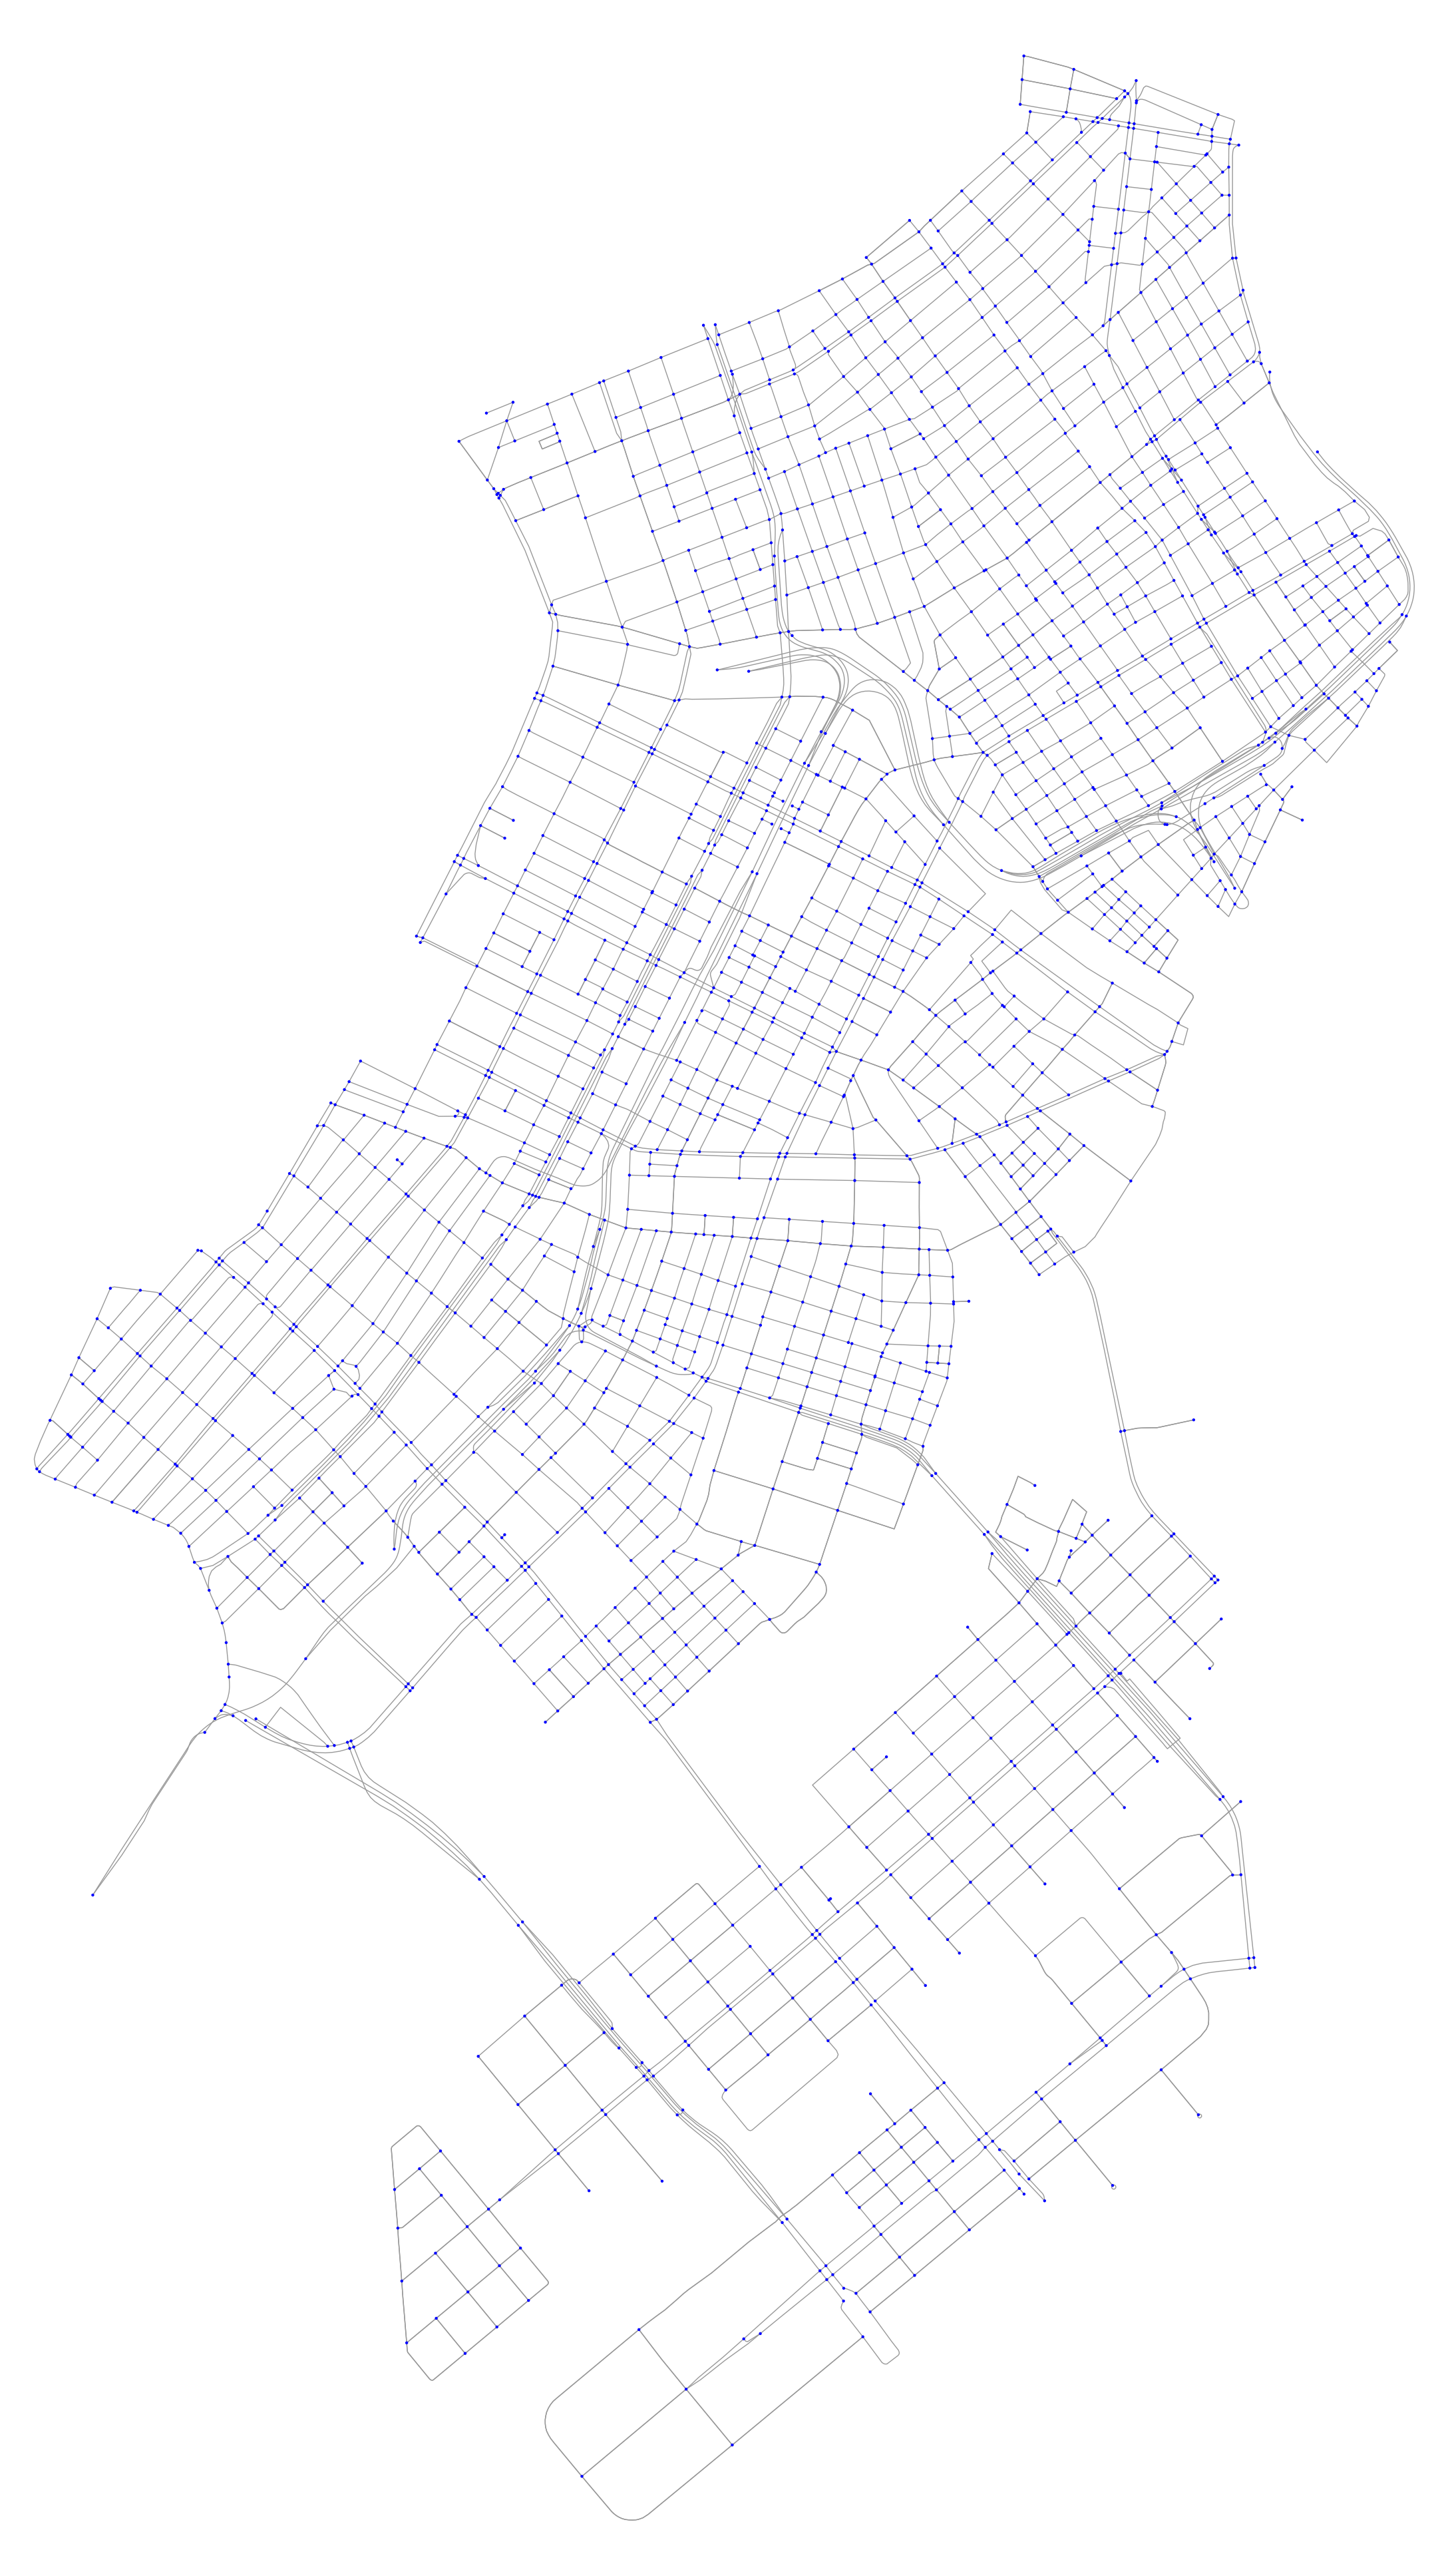

In [9]:
fig, ax = ox.plot_graph(
    G,
    figsize=(50, 50),
    bgcolor='#FFFFFF',
    node_color="b",
    node_size=10
)

## 5.6 OSMnxの基本的な統計指標

### 5.6.1 　道直比

In [10]:
# マンハッタンの道路網を取得、基本統計量を計算し、道直比の平均値を表示
nymh_stats = ox.basic_stats(ox.graph_from_place("Manhattan,New York,United States"))

In [11]:
print(f"{nymh_stats['circuity_avg']:,f}")

1.027477


In [12]:
# スタテンアイランド島の道路網を取得、基本統計量を計算し、道直比の平均値を表示
nysi_stats = ox.basic_stats(ox.graph_from_place("Staten Island,New York,United States"))

In [13]:
print(f"{nysi_stats['circuity_avg']:,f}")

1.063324


### 5.6.2 ネットワーク分析：フランス・パリの道直比

In [14]:
paris_stats = ox.basic_stats(ox.graph_from_place("Paris, France"))


In [15]:
print(f"{paris_stats['circuity_avg']:,f}")

1.030985


In [16]:
# 道路網、面積（平方メートル単位）を取得
place = 'Paris, France'
gdf = ox.geocode_to_gdf(place)
area = ox.projection.project_gdf(gdf).union_all().area
G = ox.graph_from_place(place, network_type='drive')

In [17]:
# 基本統計量を計算、マージ、表示
paris_stats = ox.basic_stats(G, area=area)
pd.Series(paris_stats)

n                                                                            9476
m                                                                           18227
k_avg                                                                    3.846982
edge_length_total                                                  1786054.326331
edge_length_avg                                                         97.989484
streets_per_node_avg                                                     3.155445
streets_per_node_counts         {0: 0, 1: 502, 2: 158, 3: 6381, 4: 2251, 5: 16...
streets_per_node_proportions    {0: 0.0, 1: 0.05297593921485859, 2: 0.01667370...
intersection_count                                                           8974
street_length_total                                                1476979.811751
street_segment_count                                                        14842
street_length_avg                                                        99.51353
circuity_avg    

In [18]:
# 辞書を個別のキーと値に展開
paris_stats = ox.basic_stats(G, area=area)
for k, count in paris_stats["streets_per_node_counts"].items():
    paris_stats["{}way_int_count".format(k)] = count
for k, proportion in paris_stats["streets_per_node_proportions"].items():
    paris_stats["{}way_int_prop".format(k)] = proportion

# 不要になった辞書要素を削除
del paris_stats["streets_per_node_counts"]
del paris_stats["streets_per_node_proportions"]

# pandas dataframeとして読み込み
pd.DataFrame(pd.Series(paris_stats, name="value")).round(3)

value
n                           9476.000
m                          18227.000
k_avg                          3.847
edge_length_total        1786054.326
edge_length_avg               97.989
streets_per_node_avg           3.155
intersection_count          8974.000
street_length_total      1476979.812
street_segment_count       14842.000
street_length_avg             99.514
circuity_avg                   1.025
self_loop_proportion           0.001
node_density_km               89.979
intersection_density_km       85.212
edge_density_km            16959.389
street_density_km          14024.587
0way_int_count                 0.000
1way_int_count               502.000
2way_int_count               158.000
3way_int_count              6381.000
4way_int_count              2251.000
5way_int_count               169.000
6way_int_count                14.000
7way_int_count                 1.000
0way_int_prop                  0.000
1way_int_prop                  0.053
2way_int_prop                  0.017
3way_int_prop                  0.673
4way_int_prop                  0.238
5way_int_prop                  0.018
6way_int_prop                  0.001
7way_int_prop                  0.000

### 5.6.3 媒介中心性

**媒介中心性**とは、ある場所やノードが、より大きなネットワークや近隣の中で、どれだけ中心的な位置にあるかを示すもの。  
パリでは、最も高い中心性を持つ地域は、その境界を通る最短経路の11%を締めていることがわかる。このことから**最短経路は通常、中心的なビジネス街や歴史的な地区の周辺に集まっており、都市全体を移動する導線として機能している。**

最新のosmnxでは`osmnx.get_digraph()`は廃止されており、代わりに`osmnx.convert.to_digraph()`を使用する

In [19]:
# Gの有向グラフ（並行エッジなし）に基づき媒介中心性を計算
bc = nx.betweenness_centrality(ox.convert.to_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
print(f"{max_node=:,f}, {max_bc=:,f}")

max_node=332,476,877.000000, max_bc=0.127910


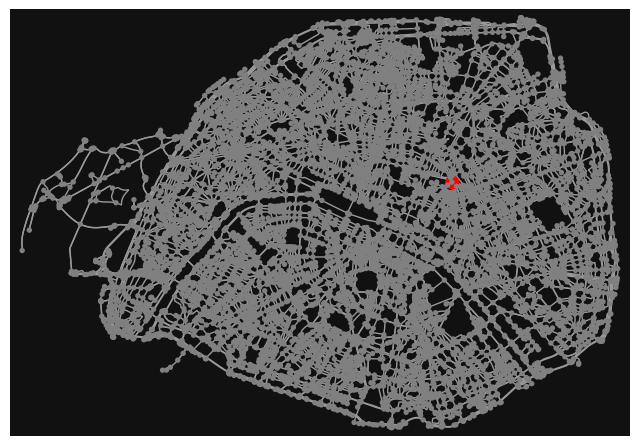

In [20]:
nc = ["r" if node == max_node else "grey" for node in G.nodes]
ns = [100 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=5)
plt.show();

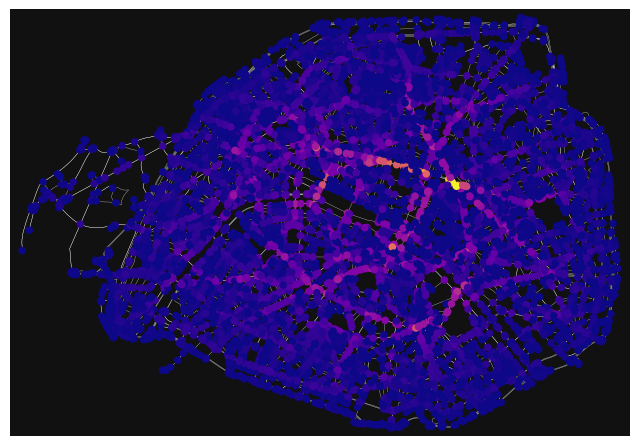

In [21]:
# 媒介中心性の値を新規ノード属性として追加、プロット
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

### 5.6.4 ネットワークの種類

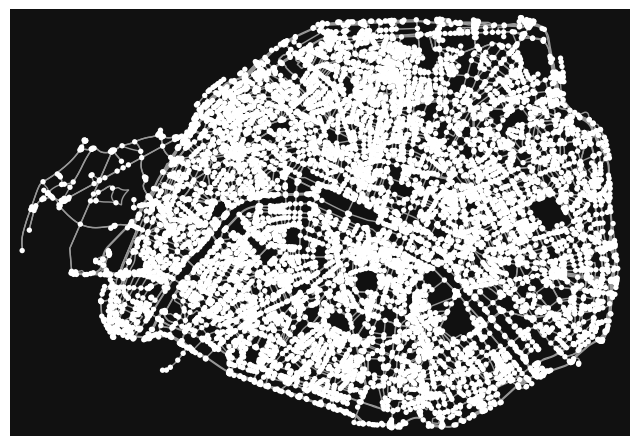

In [22]:
place_name = "Paris, France"
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)

edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)


In [23]:
edges.columns

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'reversed',
       'length', 'geometry', 'junction', 'width', 'bridge', 'tunnel', 'access',
       'ref'],
      dtype='object')

In [24]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
edges.head()

osmid      highway lanes maxspeed  \
u      v           key                                                       
125730 12179625841 0                  31093720  residential     2       30   
       244455548   0                  85735969  residential     2       30   
       567367734   0                 315818975  residential   NaN       30   
       1089076182  0    [266463585, 611974677]  residential     2       30   
125742 60912980    0                   4039102  residential   NaN       30   

                                       name  oneway reversed      length  \
u      v           key                                                     
125730 12179625841 0      Rue Louis Lumière   False    False    4.347747   
       244455548   0      Rue Louis Lumière   False     True  105.925927   
       567367734   0    Rue Henri Duvernois   False     True   35.154556   
       1089076182  0        Rue Louis Ganne   False     True  128.654471   
125742 60912980    0        Rue de Buzenval    True    False  129.018946   

                                                                 geometry  \
u      v           key                                                      
125730 12179625841 0      LINESTRING (2.41073 48.86352, 2.41072 48.86356)   
       244455548   0    LINESTRING (2.41073 48.86352, 2.41077 48.86337...   
       567367734   0    LINESTRING (2.41073 48.86352, 2.41083 48.86348...   
       1089076182  0    LINESTRING (2.41073 48.86352, 2.41062 48.86351...   
125742 60912980    0    LINESTRING (2.40137 48.85185, 2.40133 48.85192...   

                       junction width bridge tunnel access  ref  
u      v           key                                           
125730 12179625841 0        NaN   NaN    NaN    NaN    NaN  NaN  
       244455548   0        NaN   NaN    NaN    NaN    NaN  NaN  
       567367734   0        NaN   NaN    NaN    NaN    NaN  NaN  
       1089076182  0        NaN   NaN    NaN    NaN    NaN  NaN  
125742 60912980    0        NaN   NaN    NaN    NaN    NaN  NaN

In [26]:
edges['highway'].value_counts(dropna=False)

highway
residential                                   8638
primary                                       2991
tertiary                                      2483
secondary                                     2427
living_street                                  538
unclassified                                   511
trunk_link                                     185
trunk                                          146
primary_link                                   126
[residential, living_street]                    59
secondary_link                                  35
tertiary_link                                   30
[unclassified, residential]                     21
motorway_link                                   17
[living_street, tertiary]                        4
motorway                                         4
busway                                           2
[residential, tertiary]                          2
[motorway_link, trunk_link]                      1
[trunk_link, tertiary_l

## 5.7 近隣地図のカスタマイズ

### 5.7.1 場所からジオメトリを取得

In [27]:
place = "Culver City, California"
tags = {"building": True}
gdf = ox.features_from_place(place, tags=tags)
gdf.shape

(14657, 136)

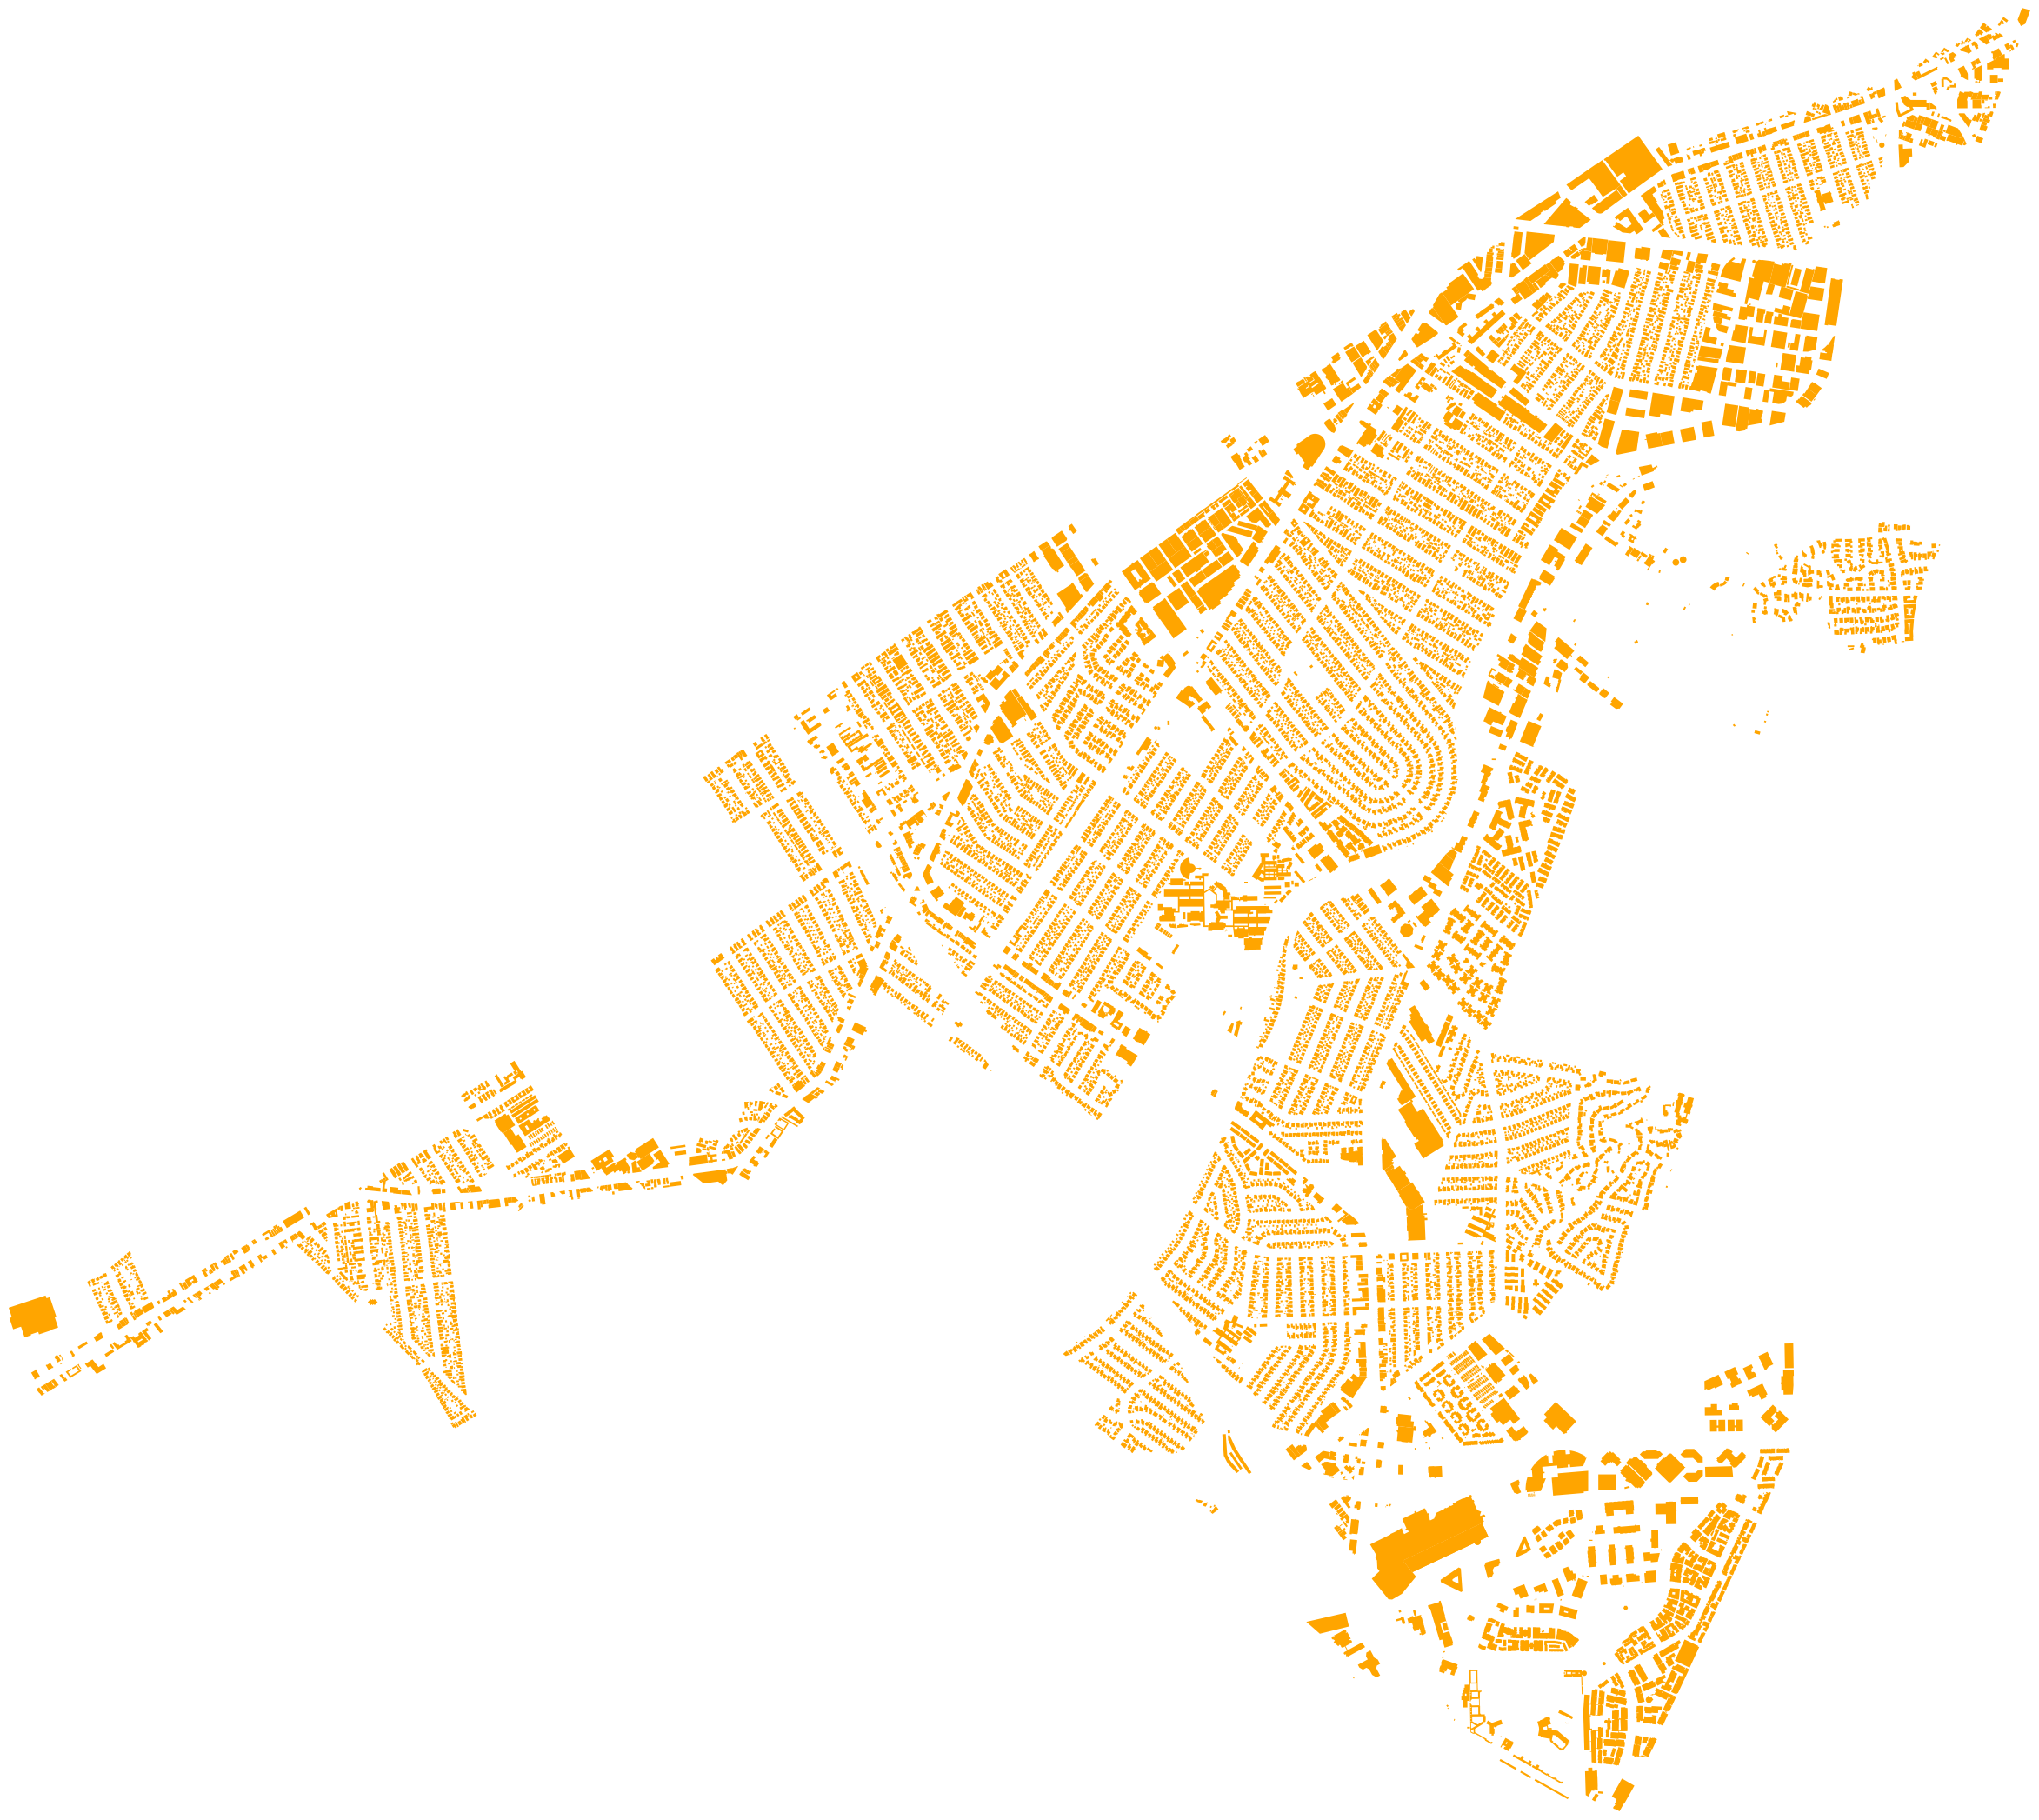

In [28]:
fig, ax = ox.plot_footprints(gdf, figsize=(30, 30), bgcolor='#FFFFFF')

### 5.7.2 座標からジオメトリを取得

(107000.0, 137000.0, 471000.0, 503000.0)

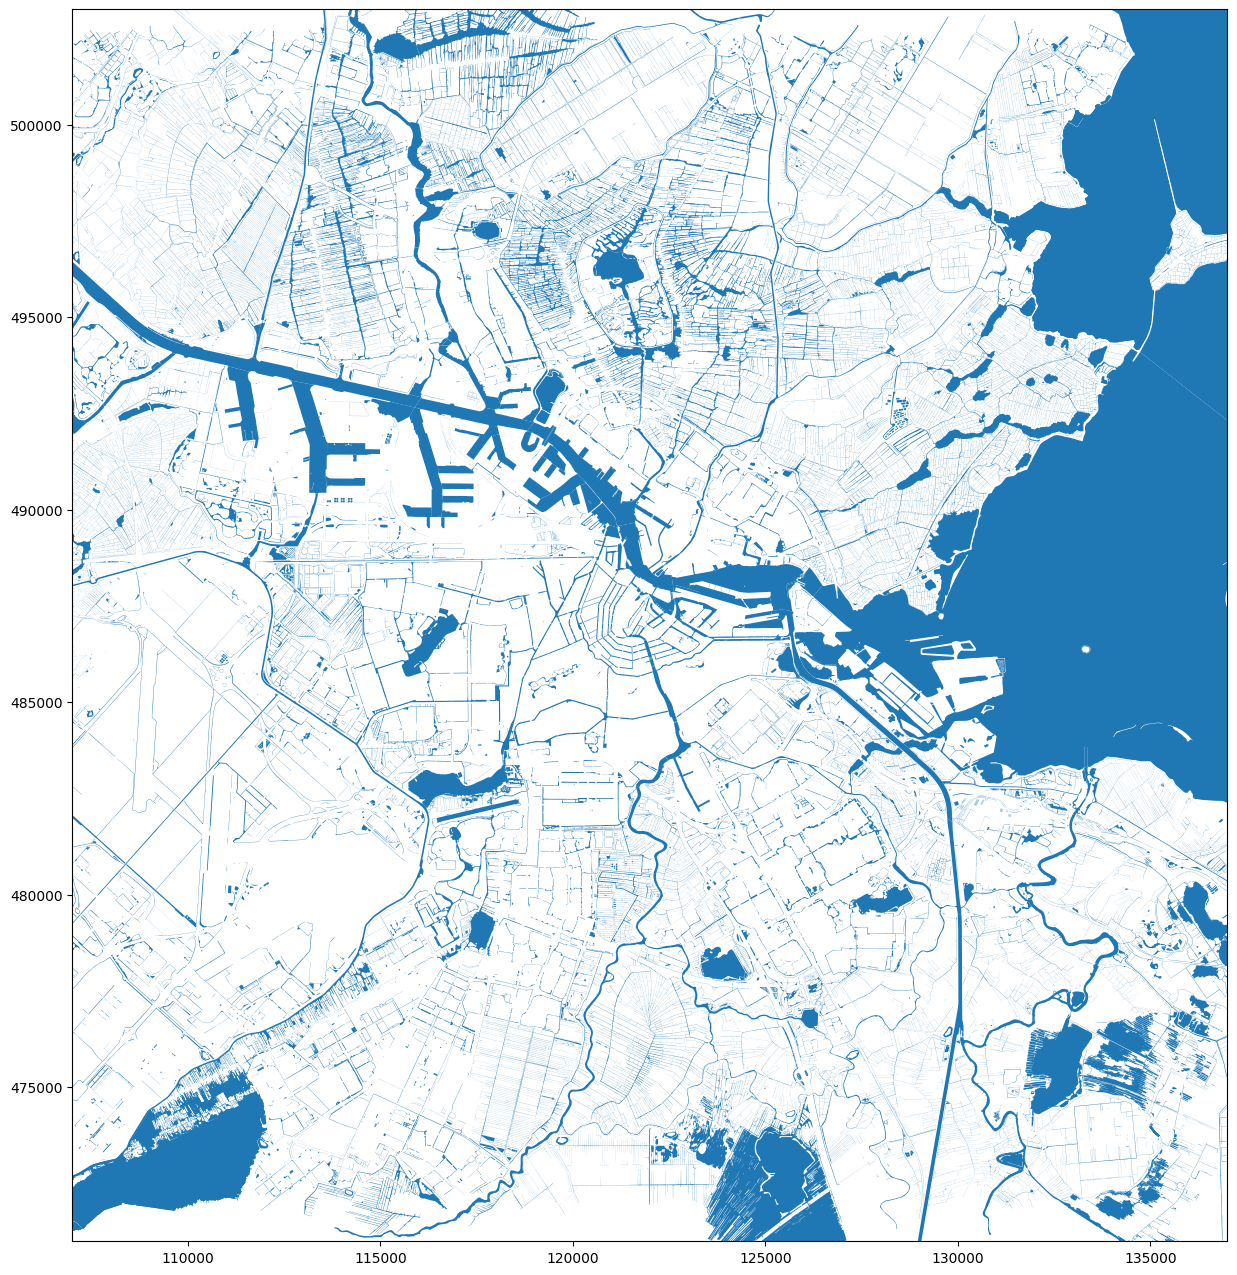

In [29]:
gdf = ox.features_from_point((52.3716, 4.9005), dist=15000, tags={'natural': 'water'})
gdf.to_crs(28992, inplace=True)
gdf.plot(figsize=(16, 16))
plt.axis([107000, 137000, 471000, 503000])

(940000.0, 1050000.0, 175000.0, 280000.0)

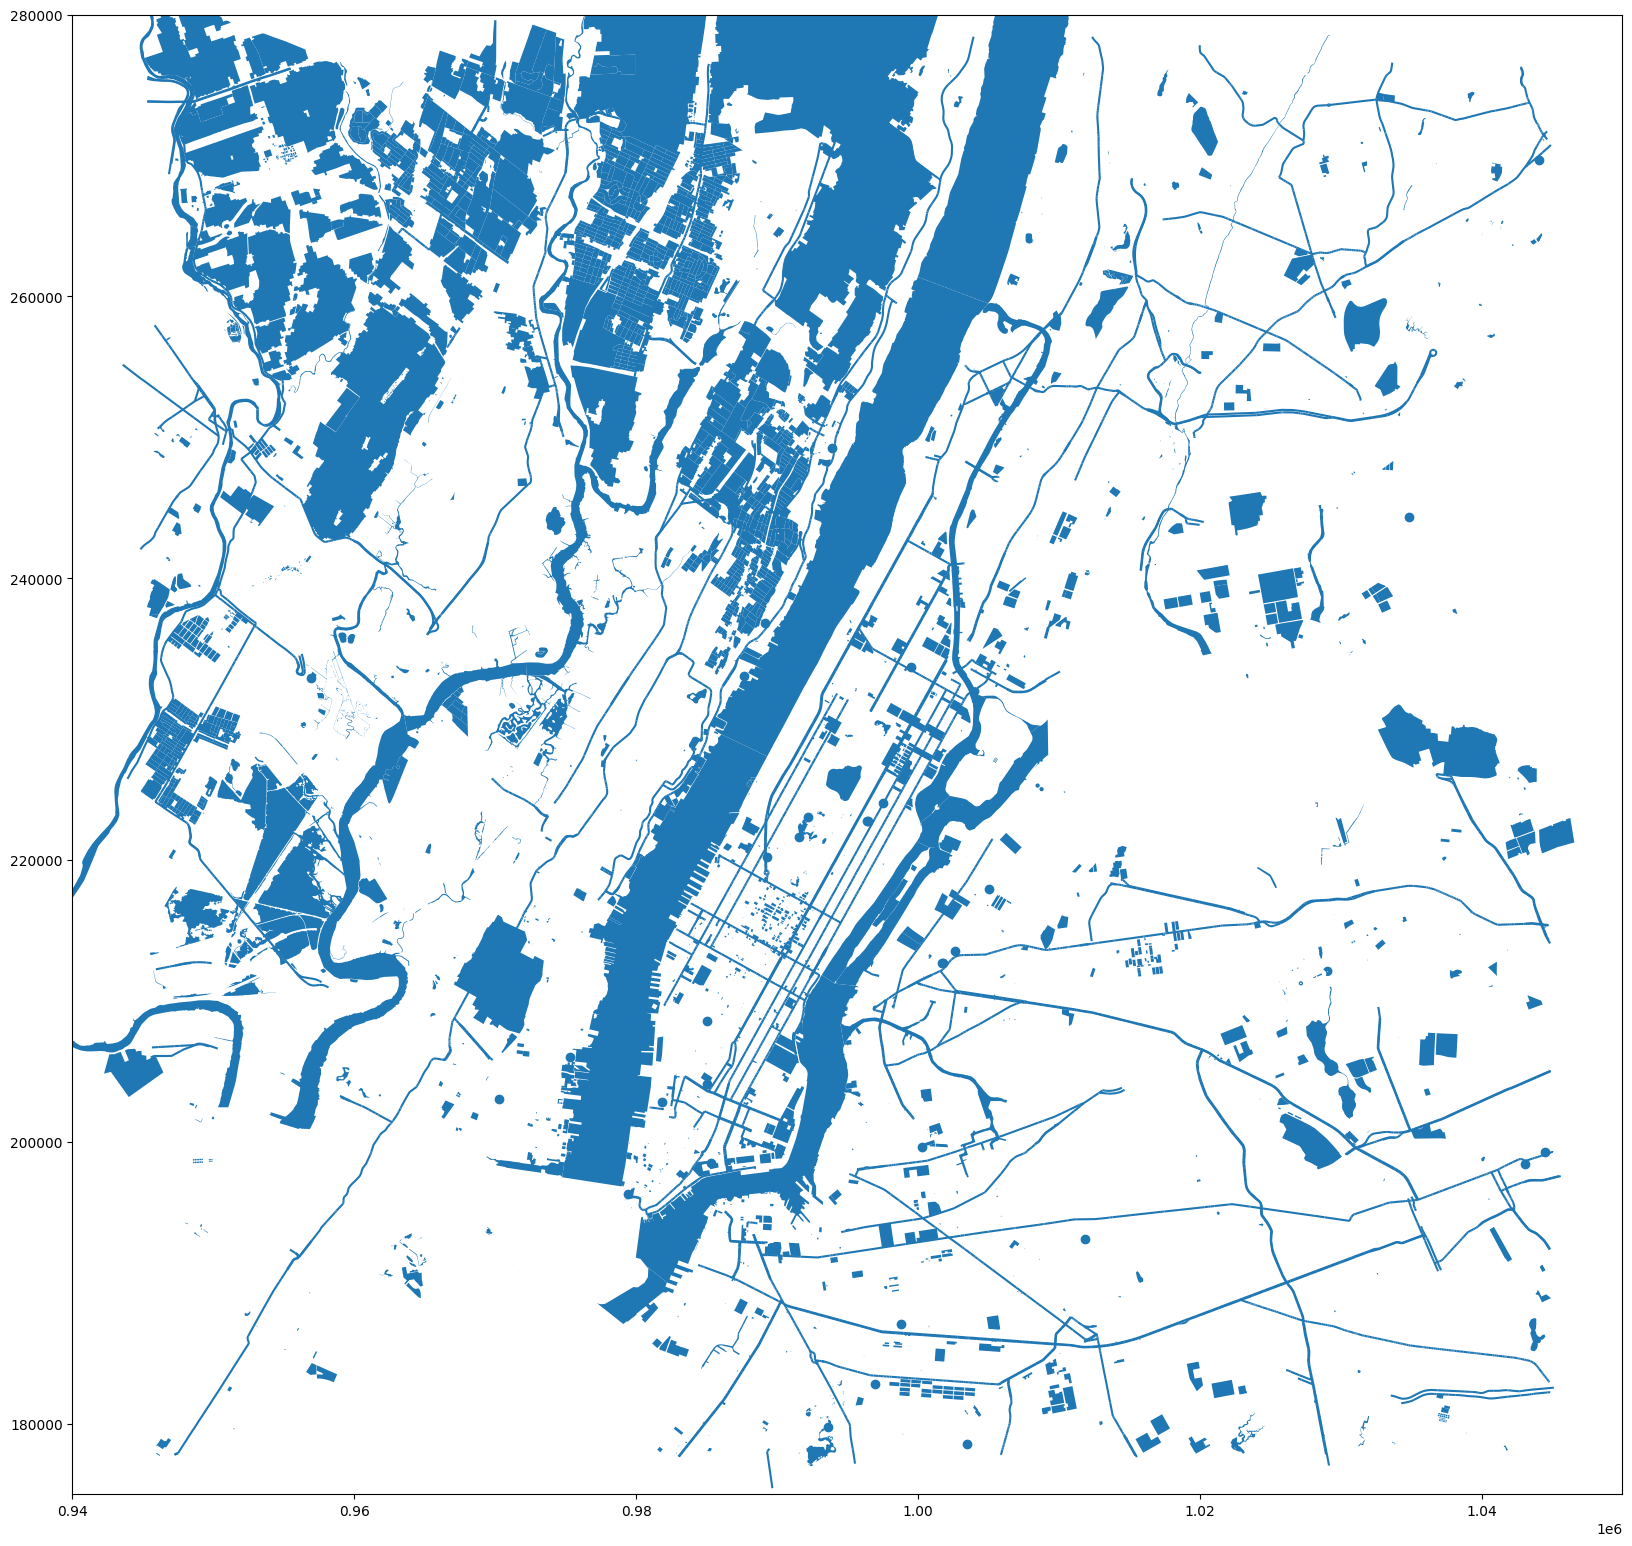

In [30]:
gdf = ox.features_from_address(('Manhattan, NY'), dist=15000, tags={'natural': 'water', 'building': 'commercial', 'landuse': 'commercial', 'landuse': 'residential', 'highway': 'unclassified', 'highway': 'primary'})
gdf.to_crs(2263, inplace=True)
gdf.plot(figsize=(20, 20))
plt.axis([940000, 1050000, 175000, 280000])

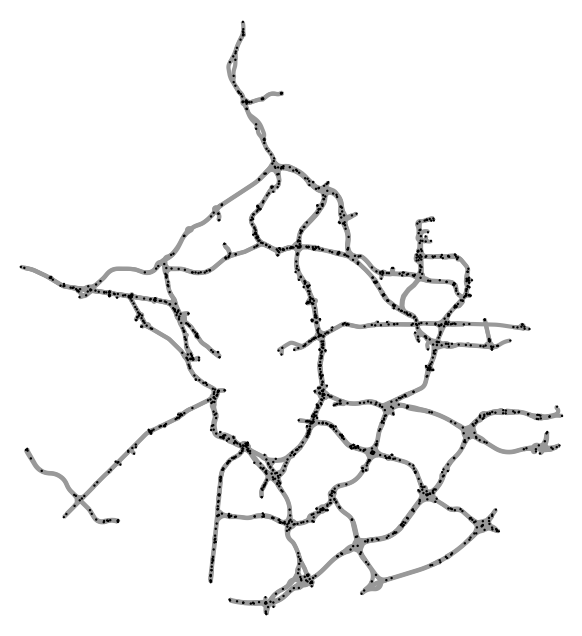

In [31]:
cf = '["highway"~"motorway|motorway_link|trunk|trunk_link"]'
G = ox.graph_from_place("Madrid, Spain", network_type="drive", custom_filter=cf)
fig, ax = ox.plot_graph(G, node_size=3, node_color='black', edge_linewidth=3, bgcolor='#FFFFFF')

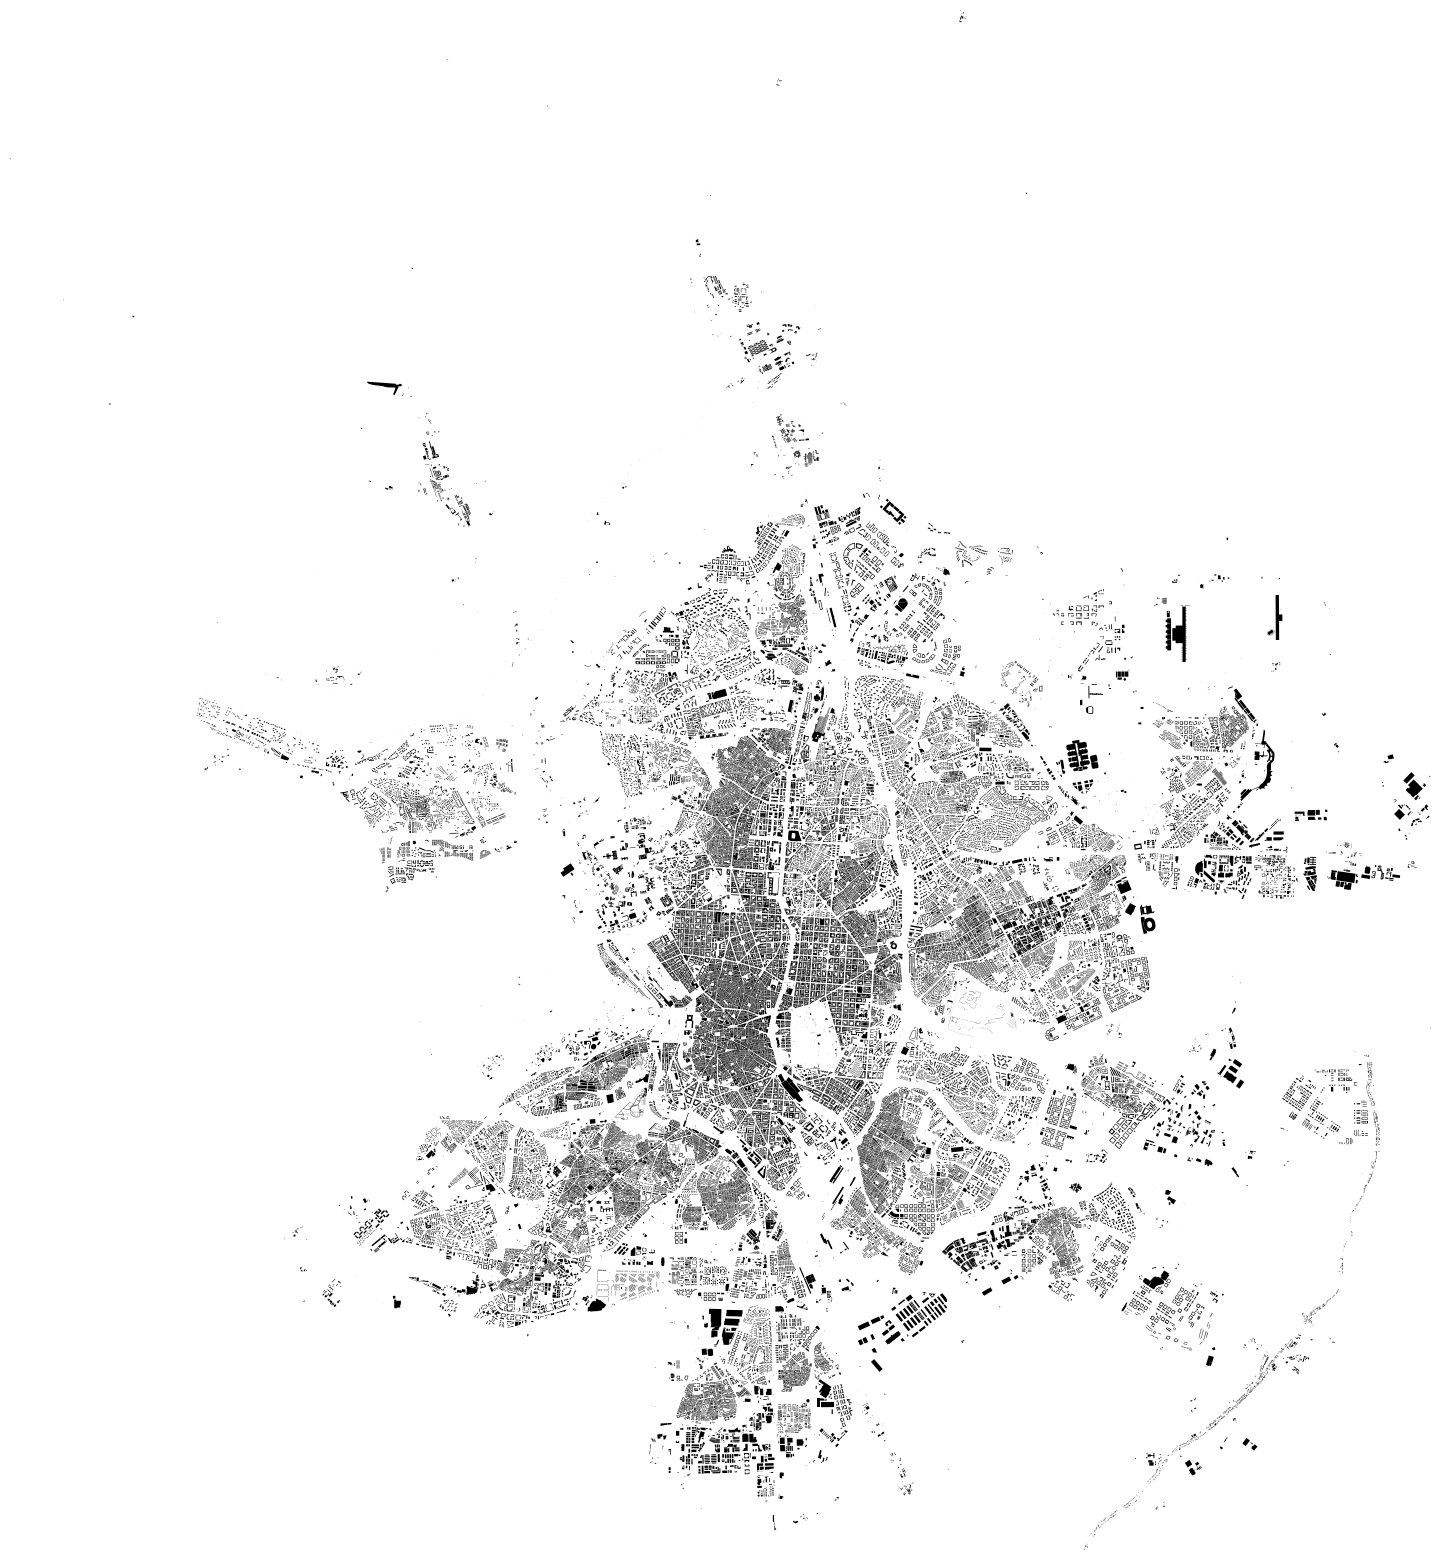

In [32]:
place = 'Madrid, Spain'
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
fig, ax = ox.plot_footprints(gdf, figsize=(20, 20), alpha=1, color='black', bgcolor='#FFFFFF', save=True, filepath='../data/05sample.png', show=True, dpi=600)